In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
import os

In [127]:
sample = pd.read_csv('../data/sample5.csv')

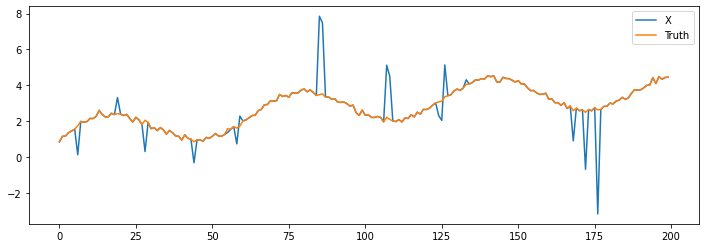

In [49]:
plt.figure(figsize=(12, 4))
sample[:200].plot(ax=plt.gca())
plt.show()

In [50]:
X = sample.X.copy()
X_train = [[i for i in X[j:j+20]] for j in range(X.shape[0] - 20)]
X_train = np.array(X_train)
Y_train = X[20:]
Y_train.index = range(0, X.shape[0] - 20)
Y_train.name = 'Y'

In [51]:
pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis=1).round(2)

0      1      2      3      4      5      6      7      8      9  \
0      0.84   1.15   1.16   1.35   1.45   1.54   0.12   1.98   1.94   1.97   
1      1.15   1.16   1.35   1.45   1.54   0.12   1.98   1.94   1.97   2.15   
2      1.16   1.35   1.45   1.54   0.12   1.98   1.94   1.97   2.15   2.14   
3      1.35   1.45   1.54   0.12   1.98   1.94   1.97   2.15   2.14   2.26   
4      1.45   1.54   0.12   1.98   1.94   1.97   2.15   2.14   2.26   2.59   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1975  20.10  19.98  20.13  16.22  17.34  19.67  19.70  19.71  19.49  19.42   
1976  19.98  20.13  16.22  17.34  19.67  19.70  19.71  19.49  19.42  19.33   
1977  20.13  16.22  17.34  19.67  19.70  19.71  19.49  19.42  19.33  19.43   
1978  16.22  17.34  19.67  19.70  19.71  19.49  19.42  19.33  19.43  19.17   
1979  17.34  19.67  19.70  19.71  19.49  19.42  19.33  19.43  19.17  19.08   

      ...     11     12     13     14     15     16     17     18     19  \
0     ...   2.14   2.26   2.59   2.37   2.23   2.24   2.43   2.36   3.31   
1     ...   2.26   2.59   2.37   2.23   2.24   2.43   2.36   3.31   2.38   
2     ...   2.59   2.37   2.23   2.24   2.43   2.36   3.31   2.38   2.31   
3     ...   2.37   2.23   2.24   2.43   2.36   3.31   2.38   2.31   2.37   
4     ...   2.23   2.24   2.43   2.36   3.31   2.38   2.31   2.37   2.15   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1975  ...  19.43  19.17  19.08  19.19  19.03  19.01  19.19  19.08  19.16   
1976  ...  19.17  19.08  19.19  19.03  19.01  19.19  19.08  19.16  18.96   
1977  ...  19.08  19.19  19.03  19.01  19.19  19.08  19.16  18.96  19.62   
1978  ...  19.19  19.03  19.01  19.19  19.08  19.16  18.96  19.62  19.09   
1979  ...  19.03  19.01  19.19  19.08  19.16  18.96  19.62  19.09  18.30   

          Y  
0      2.38  
1      2.31  
2      2.37  
3      2.15  
4      1.94  
...     ...  
1975  18.96  
1976  19.62  
1977  19.09  
1978  18.30  
1979  22.89  

[1980 rows x 21 columns]

In [59]:
def plot_prediction(reg):
    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_train)
    
    plt.figure(figsize=(12, 3))
    plt.plot(Y_train[:200], label='train')
    plt.plot(Y_pred[:200], label='prediction')
    plt.title(
        str(type(reg)).split('.')[-1].split("'")[0]
    )
    plt.legend()
    plt.show()

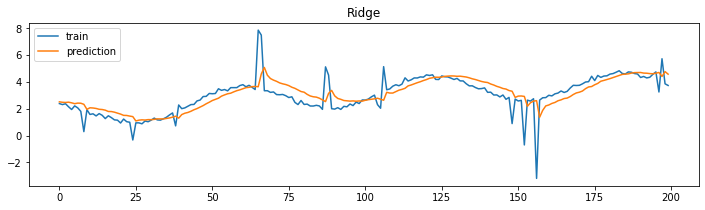

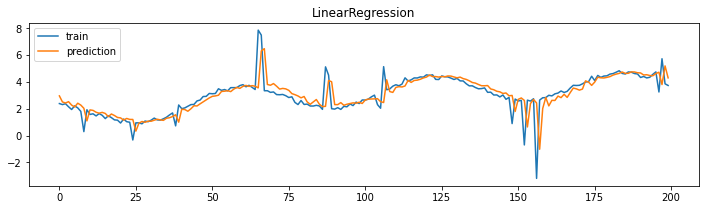

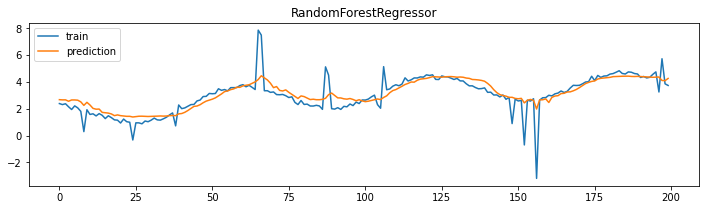

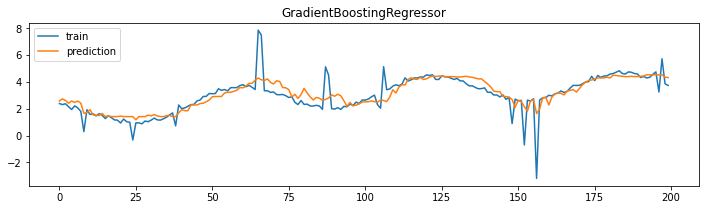

In [95]:
regs = [
    Ridge(normalize=True, alpha=0.1),
    LinearRegression(),
    RandomForestRegressor(max_features=0.1, max_depth=6, random_state=0),
    GradientBoostingRegressor(max_features=0.1, max_depth=2, random_state=0)
]
for reg in regs:
    plot_prediction(reg)

In [156]:
def dbscan_regression(X, reg):
    
    n = 1000 # number of observations for fitting
    X_clean = X.copy()
    
    for i in range(3):
    
        # calculate diff
        X_train = [[i for i in X_clean[j:j+20]] for j in range(X.shape[0] - 20)]
        X_train = np.array(X_train)
        Y_train = X_clean[20:]
        reg.fit(X_train, Y_train)
        Y_pred = reg.predict(X_train)
        
        alpha = 0.3
        fit = SimpleExpSmoothing(X[:20]).fit(alpha)
        X_smooth = fit.predict(0, 19)
        fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
        X_smooth = fit.predict(0, 19)[::-1]
        
        X_diff = X - np.concatenate([X_smooth, Y_pred])
        X_diff = X_diff / np.linalg.norm(X_diff)
        X_diff = np.reshape(X_diff, (X_diff.shape[0], 1))

        # fit eps
        eps_space = np.linspace(0.00001, 0.00025, 100)
        cluster_size = []
        for eps in eps_space:
            dbscan = DBSCAN(eps=eps).fit(X_diff[:n])
            largest_size = 0
            for label in set(dbscan.labels_):
                len_set = (dbscan.labels_ == label).sum()
                if largest_size < len_set:
                    largest_size = len_set
            cluster_size.append(largest_size / n * 100)
        cluster_size = np.array(cluster_size)
        best_eps = eps_space[np.argmax(cluster_size[1:] - cluster_size[:-1]) + 1]

        # clustering
        dbscan = DBSCAN(eps=best_eps).fit(X_diff)

        # updating
        largest_size = 0
        largest_cluster = None
        for label in set(dbscan.labels_):
            len_set = (dbscan.labels_ == label).sum()
            if largest_size < len_set:
                largest_size = len_set
                largest_cluster = label

        X_clean[dbscan.labels_ != largest_cluster] = None
        X_clean = pd.Series(X_clean).interpolate().values
        X_clean[np.argwhere(np.isnan(X_clean))] = X_smooth[np.argwhere(np.isnan(X_clean))]
    
    return X_clean

In [160]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path, reg):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = dbscan_regression(X, reg)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [164]:
dbscan_ridge_report = run_tests('../data/', Ridge())
dbscan_ridge_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.09279700988470384
File:  ../data/sample2.csv
RMSE:  0.10333497028180089
File:  ../data/sample3.csv
RMSE:  0.09418237254965013
File:  ../data/sample4.csv
RMSE:  0.11447447150924464
File:  ../data/sample5.csv
RMSE:  0.15446006003632057
File:  ../data/sample6.csv
RMSE:  1.2511665863725359
File:  ../data/sample7.csv
RMSE:  3.7609428800058438
File:  ../data/sample8.csv
RMSE:  1.5115613775291183
File:  ../data/sample9.csv
RMSE:  68.57336009893362


Sample       RMSE
0  ../data/sample1.csv   0.092797
1  ../data/sample2.csv   0.103335
2  ../data/sample3.csv   0.094182
3  ../data/sample4.csv   0.114474
4  ../data/sample5.csv   0.154460
5  ../data/sample6.csv   1.251167
6  ../data/sample7.csv   3.760943
7  ../data/sample8.csv   1.511561
8  ../data/sample9.csv  68.573360

In [162]:
dbscan_linreg_report = run_tests('../data/', LinearRegression())
dbscan_linreg_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.10047909250293816
File:  ../data/sample2.csv
RMSE:  0.1018082446594951
File:  ../data/sample3.csv
RMSE:  0.0876374824236487
File:  ../data/sample4.csv
RMSE:  0.11753502858534344
File:  ../data/sample5.csv
RMSE:  0.14922845660224665
File:  ../data/sample6.csv
RMSE:  1.2511665863725359
File:  ../data/sample7.csv
RMSE:  3.7609428800058438
File:  ../data/sample8.csv
RMSE:  1.5096699750299667
File:  ../data/sample9.csv
RMSE:  68.57336009893362


Sample       RMSE
0  ../data/sample1.csv   0.100479
1  ../data/sample2.csv   0.101808
2  ../data/sample3.csv   0.087637
3  ../data/sample4.csv   0.117535
4  ../data/sample5.csv   0.149228
5  ../data/sample6.csv   1.251167
6  ../data/sample7.csv   3.760943
7  ../data/sample8.csv   1.509670
8  ../data/sample9.csv  68.573360

In [166]:
dbscan_rforest_report = run_tests('../data/', RandomForestRegressor(random_state=0))
dbscan_rforest_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.10722869229709273
File:  ../data/sample2.csv
RMSE:  0.09858688731626956
File:  ../data/sample3.csv
RMSE:  0.08753091597969063
File:  ../data/sample4.csv
RMSE:  0.11387287771216596
File:  ../data/sample5.csv
RMSE:  0.10670377609581445
File:  ../data/sample6.csv
RMSE:  1.358775588697628
File:  ../data/sample7.csv
RMSE:  3.7125496234678934
File:  ../data/sample8.csv
RMSE:  0.4747156590746483
File:  ../data/sample9.csv
RMSE:  77.290964635535


Sample       RMSE
0  ../data/sample1.csv   0.107229
1  ../data/sample2.csv   0.098587
2  ../data/sample3.csv   0.087531
3  ../data/sample4.csv   0.113873
4  ../data/sample5.csv   0.106704
5  ../data/sample6.csv   1.358776
6  ../data/sample7.csv   3.712550
7  ../data/sample8.csv   0.474716
8  ../data/sample9.csv  77.290965

In [169]:
dbscan_gboost_report = run_tests(
    '../data/', 
    GradientBoostingRegressor(max_features=0.1, max_depth=2, random_state=0)
)
dbscan_gboost_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.1029866285216891
File:  ../data/sample2.csv
RMSE:  0.10677135972297498
File:  ../data/sample3.csv
RMSE:  0.10371675373897793
File:  ../data/sample4.csv
RMSE:  0.2398127599506771
File:  ../data/sample5.csv
RMSE:  0.22950939506195306
File:  ../data/sample6.csv
RMSE:  1.2563208986319443
File:  ../data/sample7.csv
RMSE:  4.094560087550366
File:  ../data/sample8.csv
RMSE:  1.3217897797034748
File:  ../data/sample9.csv
RMSE:  65.5805702243574


Sample       RMSE
0  ../data/sample1.csv   0.102987
1  ../data/sample2.csv   0.106771
2  ../data/sample3.csv   0.103717
3  ../data/sample4.csv   0.239813
4  ../data/sample5.csv   0.229509
5  ../data/sample6.csv   1.256321
6  ../data/sample7.csv   4.094560
7  ../data/sample8.csv   1.321790
8  ../data/sample9.csv  65.580570

In [170]:
board = pd.DataFrame(columns=['Data preparation', 'Model'] + ['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['Ridge regression', 'DBSCAN'] + list(dbscan_ridge_report['RMSE'].values)
board.loc[len(board)] = ['Linear regression', 'DBSCAN'] + list(dbscan_linreg_report['RMSE'].values)
board.loc[len(board)] = ['Random forest', 'DBSCAN'] + list(dbscan_rforest_report['RMSE'].values)
board.loc[len(board)] = ['Gradient boosting', 'DBSCAN'] + list(dbscan_gboost_report['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3   sample4   sample5  \
Data preparation  Model                                                      
Ridge regression  DBSCAN  0.092797  0.103335  0.094182  0.114474  0.154460   
Linear regression DBSCAN  0.100479  0.101808  0.087637  0.117535  0.149228   
Random forest     DBSCAN  0.107229  0.098587  0.087531  0.113873  0.106704   
Gradient boosting DBSCAN  0.102987  0.106771  0.103717  0.239813  0.229509   

                           sample6   sample7   sample8    sample9  
Data preparation  Model                                            
Ridge regression  DBSCAN  1.251167  3.760943  1.511561  68.573360  
Linear regression DBSCAN  1.251167  3.760943  1.509670  68.573360  
Random forest     DBSCAN  1.358776  3.712550  0.474716  77.290965  
Gradient boosting DBSCAN  1.256321  4.094560  1.321790  65.580570

In [171]:
board.to_csv('../results/regression_models.csv')